In [1]:
from lambeq import BobcatParser, AtomicType, RemoveCupsRewriter, UnifyCodomainRewriter, Rewriter, IQPAnsatz
from lambeq.backend.grammar import Spider
from discopro.anaphora import connect_anaphora_on_top
from discopro.grammar import tensor
import pandas as pd
import numpy as np
import os, sys, datetime, pickle
from tqdm import tqdm

remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3)

In [2]:
def sent2dig(sentence, pro1, ref, pro2=None):
    diagram = parser.sentence2diagram(sentence)
    #diagram = diagram >> Spider(S, 2, 1)
    pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if (box.name.casefold() == pro1.casefold() or box.name.casefold() == pro2.casefold()))
    ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
    diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
    diagram = rewriter(remove_cups(diagram)).normal_form()
    return diagram

In [3]:
def gen_labels(path: str, verbose=False, frac=1, save=False):
    df = pd.read_pickle(path)
    df = df.sample(frac=frac)
    
    if not os.path.exists(os.getcwd()+'/err_logs'):
        os.mkdir(os.getcwd()+'/err_logs')
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    f = open("err_logs/log_"+path.split('/')[-1].split('.')[-2]+'_'+timestamp+".txt", 'w')
    
    circuits, labels, diagrams = [],[],[]
    sentences = []
    for i, row in tqdm(df.iterrows(), total=len(df), position=0, leave=True):
        sentence, pro1, pro2, right_ref, wrong_ref = row[['Sentence', 'Pronoun 1', 'Pronoun 2', 'Right Referent', 'Wrong Referent']]

        try:
            diagram_right = sent2dig(sentence.strip(), pro1.strip(), right_ref.strip(), pro2.strip())
            diagram_wrong = sent2dig(sentence.strip(), pro1.strip(), wrong_ref.strip(), pro2.strip())
            diagrams.append(diagram_right)
            circuits.append(ansatz(diagram_right))
            labels.append([0,1])
            sentences.append(sentence)
            diagrams.append(diagram_wrong)
            circuits.append(ansatz(diagram_wrong))
            labels.append([1,0])
            sentences.append(sentence)
        except Exception as err:
            tqdm.write(f"Error: {err}".strip(), file=f)
            if verbose:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
    f.close()
    if save:
        f = open('wino/data/circuits_'+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")+'.pkl', 'wb')
        pickle.dump(list(zip(sentences, circuits)), f)
        f.close()
    return circuits, labels, diagrams

In [ ]:
gen_labels(path="wino/data/train_data.pkl", save=True)

 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 847/1584 [05:49<04:46,  2.57it/s]

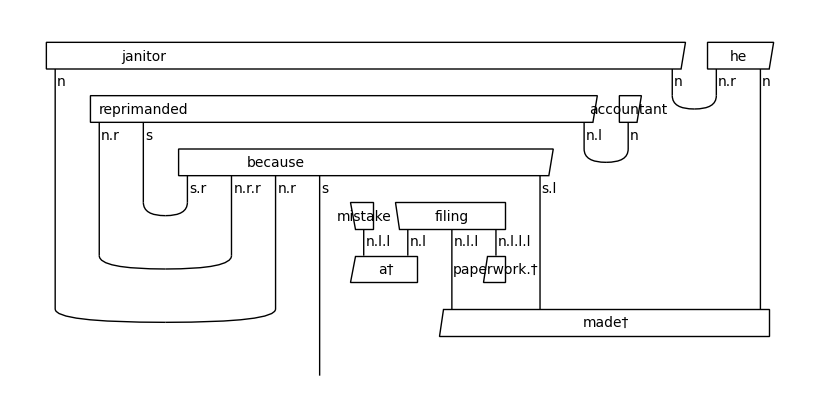

In [38]:
sent2dig("The janitor reprimanded the accountant because he made a mistake filing paperwork.", "he", "janitor").draw(figsize=(8,4))

In [40]:
diagram1 = parser.sentence2diagram("The janitor reprimanded the accountant")
diagram2 = parser.sentence2diagram("he made a mistake filing paperwork")
diagram = tensor(diagram1, diagram2)
diagram = diagram >> Spider(S, 2, 1)
pro, ref = 'he', 'janitor'
pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
diagram = rewriter(remove_cups(diagram)).normal_form()

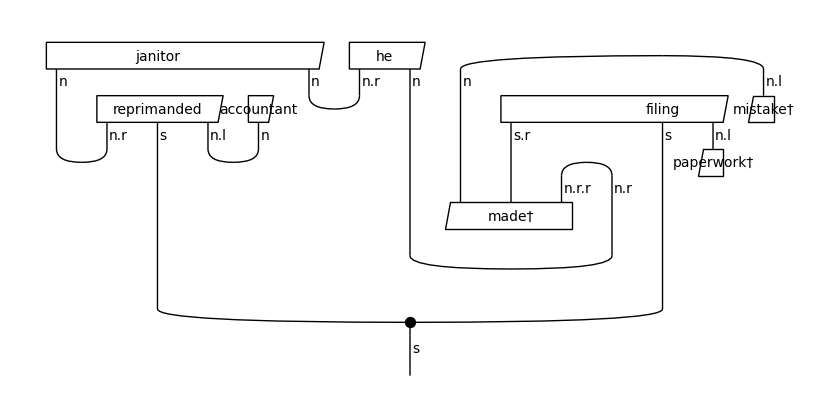

In [41]:
diagram.draw(figsize=(8,4))